# Modelagem de Dados
Este notebook pertence ao projeto: Case Téc­ni­co Data Sci­en­ce - iFo­od acessível em \
https://github.com/paulolaque/ifood-case.git

## Procedimentos iniciais

### Importação de bibliotecas

In [0]:
import os
import random
# Este notebook executa em pyspark, favor instalar caso necessário
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, when, collect_list, explode, struct, lit, max as spark_max
    from pyspark.sql.window import Window
    from pyspark.ml.feature import StringIndexer, VectorAssembler
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import BinaryClassificationEvaluator

except ImportError:
    print("PySpark não está instalado. Instale com: pip install pyspark")
    sys.exit(1)

spark = SparkSession.builder.getOrCreate()

### Configuração de diretórios

In [0]:
# Detectar se está rodando no Databricks, pois o padrão de diretórios podem ser diferentes de uma máquina local
running_in_databricks = os.path.exists("/databricks/driver")

# Ajusta o caminho raiz do projeto
if running_in_databricks:
    project_root = "/dbfs" + os.getcwd().split("/notebooks")[0]  # raiz do workspace em DBFSpara Databricks
else:
    project_root = os.path.abspath("..")  # pasta acima de notebooks/

# Cria string de diretório
parquet_path_transformed = os.path.join(project_root, "data", "processed", "unificado_transformed.parquet")
parquet_path = os.path.join(project_root, "data", "processed", "unificado.parquet")

## Carregamento e Leitura dos Dados

In [0]:
# Carrega os dados processados
offers = spark.read.parquet(parquet_path_transformed)
df = spark.read.parquet(parquet_path)
offers.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- time_since_test_start: double (nullable = true)
 |-- event: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- reward: double (nullable = true)
 |-- amount_is_null: integer (nullable = true)
 |-- reward_is_null: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- credit_card_limit_is_null: integer (nullable = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- channel_mobile: integer (nullable = true)
 |-- channel_email: integer (nullable = true)
 |-- channel_social: integer (nullable = true)
 |-- channel_web: integer (nullable = true)
 |-- is_offer_id_null: integer (nullable = true)
 |-- registered_on_date: date (nullable = true)
 |-- dias_desde_registro: int

## Transformações Vetoriais

In [0]:
#  Selecionar colunas para modelagem
model_data = offers.select(
    "converted",
    "offer_type",
    "min_value",
    "duration",
    "discount_value",
    "age",
    "credit_card_limit",
    "gender",
    "credit_card_limit_is_null",
    "channel_mobile",
    "channel_email",
    "channel_social",
    "channel_web",
    "dias_desde_registro",
    "ano_registro",
    "mes_registro",
    "semana_registro"
)

# Tratar nulos antes do StringIndexer
model_data = model_data.fillna({
    "offer_type": "unknown",
    "gender": "unknown"
})

# 10. Encoding
indexers = [
    StringIndexer(inputCol="offer_type", outputCol="offer_type_idx"),
    StringIndexer(inputCol="gender", outputCol="gender_idx")
]

for indexer in indexers:
    model_data = indexer.fit(model_data).transform(model_data)

# 11. Montar vetor de features
assembler = VectorAssembler(
    inputCols=["offer_type_idx", "min_value", "duration", "discount_value", "age", "credit_card_limit", "gender_idx","credit_card_limit_is_null",
    "channel_mobile",
    "channel_email",
    "channel_social",
    "channel_web",
    "dias_desde_registro",
    "ano_registro",
    "mes_registro",
    "semana_registro"],
    outputCol="features"
)

data = assembler.transform(model_data).select("features", "converted")

## Treino

In [0]:
# Separação Treino teste
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Modelo base
rf = RandomForestClassifier(labelCol="converted", featuresCol="features", seed=42)


## Tuning do Modelo

In [0]:
# Simulação de Random Search: amostra aleatória de parâmetros
n_random = 8  
all_params = []

for _ in range(n_random):
    num_trees = random.choice([20, 50, 100, 200])
    max_depth = random.choice([3, 5, 10, 15, 20])
    min_instances = random.choice([1, 2, 5])

    all_params.append({
        rf.numTrees: num_trees,
        rf.maxDepth: max_depth,
        rf.minInstancesPerNode: min_instances
    })

# Criar um ParamGridBuilder manualmente
grid = ParamGridBuilder()
for param_set in all_params:
    grid.addGrid(rf.numTrees, [param_set[rf.numTrees]])
    grid.addGrid(rf.maxDepth, [param_set[rf.maxDepth]])
    grid.addGrid(rf.minInstancesPerNode, [param_set[rf.minInstancesPerNode]])

param_grid = grid.build()

# Avaliador
evaluator = BinaryClassificationEvaluator(labelCol="converted", metricName="areaUnderROC")

# CrossValidator
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,  # Ajuste conforme sua infra
    seed=42
)

# Treinamento com validação cruzada
cv_model = cv.fit(data)

# Melhor modelo
best_model = cv_model.bestModel
print(f"Melhor numTrees: {best_model.getNumTrees}")
print(f"Melhor maxDepth: {best_model.getOrDefault('maxDepth')}")
print(f"Melhor minInstancesPerNode: {best_model.getOrDefault('minInstancesPerNode')}")


Melhor numTrees: 50
Melhor maxDepth: 5
Melhor minInstancesPerNode: 2


## Avaliação

In [0]:
# AUC do melhor modelo
auc = evaluator.evaluate(best_model.transform(data))
print(f"AUC: {auc:.4f}")

AUC: 0.7325


## Resultado

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

# Dados únicos
unique_clients = df.select("account_id", "age", "gender", "credit_card_limit", 
                           "credit_card_limit_is_null", "dias_desde_registro", 
                           "ano_registro", "mes_registro", "semana_registro",
                           "channel_mobile", "channel_email", "channel_social", "channel_web").distinct()

unique_offers = df.select("offer_id", "offer_type", "min_value", "duration", "discount_value").dropna().distinct()

# Cross join
candidates = unique_clients.crossJoin(unique_offers)

# Substituir nulos
candidates = candidates.fillna({
    "offer_type": "unknown",
    "gender": "unknown"
})

# Indexadores
indexers = [
    StringIndexer(inputCol="offer_type", outputCol="offer_type_idx"),
    StringIndexer(inputCol="gender", outputCol="gender_idx")
]

for indexer in indexers:
    candidates = indexer.fit(candidates).transform(candidates)

# Vetor de features
candidate_features = assembler.transform(candidates)

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

predictions = best_model.transform(candidate_features)

# Pegar probabilidade positiva
get_prob = udf(lambda v: float(v[1]), DoubleType())
predictions = predictions.withColumn("positive_probability", get_prob(col("probability")))

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy("account_id").orderBy(col("positive_probability").desc())

best_offers = predictions.withColumn("rank", row_number().over(windowSpec)) \
    .filter(col("rank") == 1)

from pyspark.sql.functions import col

impact = best_offers.withColumn("expected_conversion", col("positive_probability")) \
    .withColumn("expected_revenue", col("expected_conversion") * col("min_value")) \
    .withColumn("expected_cost", col("expected_conversion") * col("discount_value"))

impact_summary = impact.agg(
    {"expected_conversion": "sum", 
     "expected_revenue": "sum", 
     "expected_cost": "sum"}
).withColumnRenamed("sum(expected_conversion)", "total_expected_conversions") \
 .withColumnRenamed("sum(expected_revenue)", "total_expected_revenue") \
 .withColumnRenamed("sum(expected_cost)", "total_expected_cost")

impact_summary.show()


+--------------------------+----------------------+-------------------+
|total_expected_conversions|total_expected_revenue|total_expected_cost|
+--------------------------+----------------------+-------------------+
|        13978.336352313218|    219617.44926083766|  69884.77766411904|
+--------------------------+----------------------+-------------------+



## Visualizações

### Feature Importance

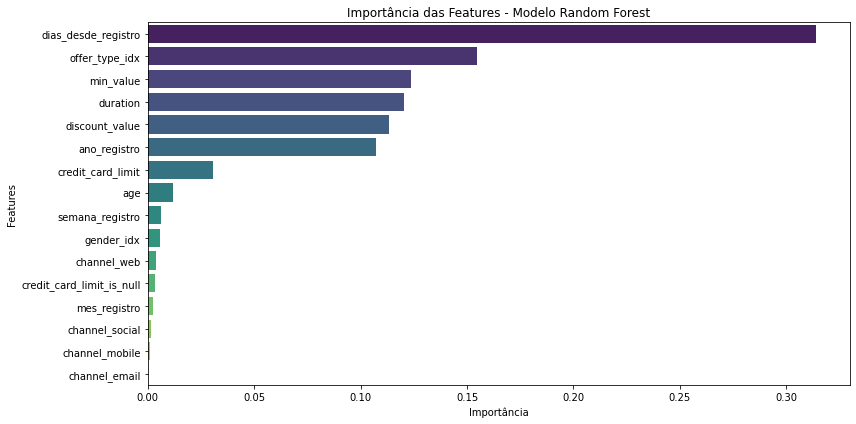

dias_desde_registro: 0.3140
offer_type_idx: 0.1545
min_value: 0.1236
duration: 0.1202
discount_value: 0.1134
ano_registro: 0.1072
credit_card_limit: 0.0307
age: 0.0118
semana_registro: 0.0062
gender_idx: 0.0057
channel_web: 0.0038
credit_card_limit_is_null: 0.0035
mes_registro: 0.0026
channel_social: 0.0017
channel_mobile: 0.0010
channel_email: 0.0000


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Obter importância das features
importances = best_model.featureImportances
feature_names = assembler.getInputCols()
feature_importance_list = list(zip(feature_names, importances.toArray()))
feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# 2. Criar DataFrame
importance_df = pd.DataFrame(feature_importance_list, columns=["feature", "importance"])

# 3. Plotar gráfico de barras das importâncias
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")
plt.title("Importância das Features - Modelo Random Forest")
plt.xlabel("Importância")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Mostrar
for name, score in feature_importance_list:
    print(f"{name}: {score:.4f}")



### Taxas de conversão 

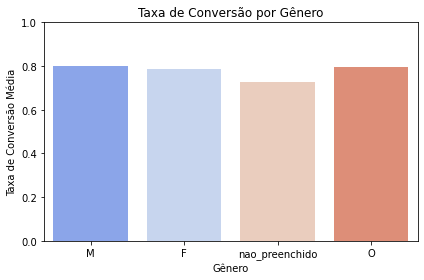

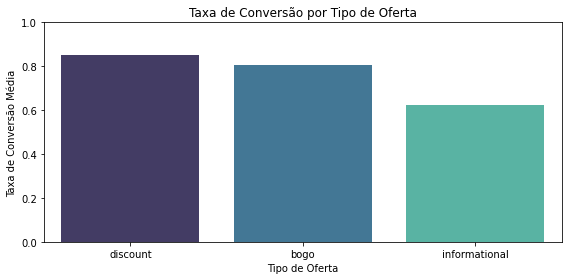

In [0]:
# Calcular média de conversão por valor de gender_idx
gender_stats = model_data.groupBy("gender", "gender_idx").agg({"converted": "mean"}).toPandas()
gender_stats = gender_stats.sort_values("gender_idx")

# Plotar
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_stats, x="gender", y="avg(converted)", palette="coolwarm")
plt.title("Taxa de Conversão por Gênero")
plt.ylabel("Taxa de Conversão Média")
plt.xlabel("Gênero")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Calcular média de conversão por offer_type_idx
offer_stats = model_data.groupBy("offer_type", "offer_type_idx").agg({"converted": "mean"}).toPandas()
offer_stats = offer_stats.sort_values("offer_type_idx")

# Plotar
plt.figure(figsize=(8, 4))
sns.barplot(data=offer_stats, x="offer_type", y="avg(converted)", palette="mako")
plt.title("Taxa de Conversão por Tipo de Oferta")
plt.ylabel("Taxa de Conversão Média")
plt.xlabel("Tipo de Oferta")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
